In [1]:
import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import svd
from numpy.linalg import lstsq
from scipy.spatial.distance import cdist
%load_ext autoreload
%autoreload 2

def clean_matrix(X, tol=1e-14):
    '''
    
    clean small values in a matrix
    '''            
    X[abs(X)<tol] = 0.
    return X

def calculate_svd_solution(A,b):
    U, S, V = svd(A)
    clean_matrix(U)
    clean_matrix(S)
    clean_matrix(V)
    S_inv = np.zeros((A.T.shape))
    for i in range(min(A.T.shape)):
        if S[i] != 0:
            S_inv[i, i] = 1./S[i]
    x = np.matmul(np.transpose(V), np.matmul(S_inv, np.matmul(np.transpose(U), b)))
    return x

def getZ(X, Y, W):
    return W[0]*X+W[1]*Y+W[2]

def smoothness(best_W_list, X, y):
    p = None
    for W in best_W_list:
        best_W = W["W"]
        if p is None:
            p = np.abs(X.dot(best_W)-y)/np.sqrt(best_W[0]**2+best_W[1]**2+1)
        else:
            p = np.concatenate([p, np.abs(X.dot(best_W)-y)/np.sqrt(best_W[0]**2+best_W[1]**2+1)], axis=1)
    p = np.argmin(p, axis=1)
    mean_dist = []
    for i in range(4):
        ids = (p == i)
        best_W = best_W_list[i]["W"]
        mean = np.mean(np.abs(X[ids].dot(best_W)-y[ids])/np.sqrt(best_W[0]**2+best_W[1]**2+1))
        mean_dist.append(mean)
    
    print(mean_dist)
    print(best_W_list[np.argmin(mean_dist)]["W"])

(-2.41214353288031,
 -0.09240396232476322,
 -3.249568080243544,
 -0.4356311595844572)

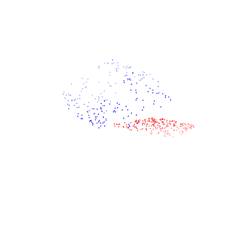

In [2]:
from scipy.stats import ortho_group
R1 = ortho_group.rvs(dim=3)
R2 = ortho_group.rvs(dim=3)
fig = plt.figure()
ax = plt.axes(projection='3d')

clear_table = np.loadtxt("./data/clear_table.txt")
clear_hallway = np.loadtxt("./data/clean_hallway.txt")
selected1 = np.random.choice(clear_table.shape[0], 200, replace=False)
selected2 = np.random.choice(clear_hallway.shape[0], 200, replace=False)
clear_table = clear_table[selected1]
clear_hallway = clear_hallway[selected2]
clear_table_ = clear_table.dot(R1)
clear_hallway_ = clear_hallway.dot(R2)
# X1 = np.concatenate([clear_table[:, [0,2]], np.ones((clear_table.shape[0],1))], axis=1)
# y1 = clear_table[:, [1]]
# X2 = np.concatenate([clear_hallway[:, [0,2]], np.ones((clear_hallway.shape[0],1))], axis=1)
# y2 = clear_hallway[:, [1]]
ax = plt.axes(projection='3d')
ax.scatter3D(clear_table_[:,0], clear_table_[:,2], clear_table_[:,1], c='r', s=0.1, label="object 1")
ax.scatter3D(clear_hallway_[:,0], clear_hallway_[:,2], clear_hallway_[:,1], c='b', s=0.1, label="object 2")
plt.axis("off")
# plt.savefig("proposal_2.png", bbox_inches="tight")

In [3]:
orig = np.concatenate([clear_hallway, clear_table], axis=0)
transformed = np.concatenate([clear_hallway_, clear_table_], axis=0)
# rand1 = np.random.permutation(orig.shape[0])
# rand2 = np.random.permutation(transformed.shape[0])
# orig = orig[rand1]
# transformed = transformed[rand2]

In [4]:
def find_cluster(orig, transformed):
    a = np.expand_dims(orig, axis=1).repeat(orig.shape[0], axis=1)
    b = np.transpose(a, [1,0,2])
    feat1 = np.sqrt(np.sum((a-b)**2, axis=2))
    a = np.expand_dims(transformed, axis=1).repeat(transformed.shape[0], axis=1)
    b = np.transpose(a, [1,0,2])
    feat2 = np.sqrt(np.sum((a-b)**2, axis=2))
#     dm = cdist(feat1, feat2, lambda u, v: len(np.intersect1d(u, v)))
#     match = np.argmax(dm, axis=1)
    point_num = orig.shape[0]
    
    cat = np.ones(point_num)*-1
    
    corres = np.ones(point_num)*-1
    
    unmatched_point = set(np.arange(point_num))
    
    cat_id = 0
    
    while len(unmatched_point)>0:
        while True:
            ref_point_index = np.random.choice(np.array(list(unmatched_point)), 4, replace=False)
            dm = cdist(feat1[ref_point_index], feat2, lambda u, v: len(np.intersect1d(u, v)))
            match = np.argmax(dm, axis=1)
            m = feat1[ref_point_index, :][:, ref_point_index]
            n = feat2[match, :][:, match]
            if np.isclose(m,n).all():
                break
        ref_feat1 = feat1[ref_point_index, :].T  # shape (n,4)
        ref_feat2 = feat2[match, :].T  # shape (n,4)
        
        dist = cdist(ref_feat1, ref_feat2)
        
        in_class = np.min(dist, axis=1) < 1e-9
        matched_point = np.argmin(dist, axis=1)
        cat[in_class] = cat_id
        unmatched_point = unmatched_point - set(in_class.nonzero()[0])
        corres[in_class] = matched_point[in_class]
        
        cat_id += 1
    
    return cat, corres

In [5]:
cat, corres = find_cluster(orig, transformed)

In [14]:
corres.shape

(400,)

In [12]:
print("Det: R1: {}, R2: {}".format(np.linalg.det(R1), np.linalg.det(R2)))

Det: R1: 0.9999999999999998, R2: 1.0000000000000002


## Transform Estimation using DLT

In [13]:
from src.register import register
from src.register import tf
from src.register import errFunc
from src.register import invRodrigues

clusters = set(cat)
matched_pts1 = orig
matched_pts2 = transformed[corres.astype(int), :]

final_pts1 = np.zeros_like(matched_pts1)
final_pts2 = np.zeros_like(matched_pts2)

(r, c) = final_pts1.shape

ret_mat = None

for val in clusters:
    point_mask = (cat == val)
    l = point_mask.sum()
    this_pts1 = matched_pts1[point_mask]
    this_pts2 = matched_pts2[point_mask]
    tf_mat = register(this_pts1.T, this_pts2.T, rigid=True)
    ret_mat = tf_mat if ret_mat is None else ret_mat
    
    homo_pts1 = np.vstack((this_pts1.T, np.ones((1, l))))
    homo_pts2 = np.vstack((this_pts2.T, np.ones((1, l))))
    
    recovered = np.dot(tf_mat, homo_pts1)
    err = errFunc(tf_mat, homo_pts1, homo_pts2).sum()
    print("Err: {}".format(err))

Ransac result err 3.6525925513342106e-13
Err: 1.425711328509327e-12
Ransac result err 3.0050406607529112e-12
Err: 3.729817177333672e-09


In [23]:
from src.noise import destroy_match

In [21]:
a = np.arange(50)

In [24]:
destroy_match(a) - a

[44 12 15 20  9 48 10  5 27  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [41]:
np.random.shuffle(a[0:3])

In [42]:
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [30]:
idx = np.array([1, 2, 3, 4])

In [39]:
np.random.shuffle(a[idx])

In [40]:
a

array([ 0,  2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])